Aerogeophysical Spectrometric Data Layer

1. Installing Required Libraries

In [ ]:
pip install rasterio numpy scipy matplotlib

2. Pre Processing Raster Data

In [ ]:
import rasterio
import numpy as np
from scipy.ndimage import gaussian_filter


input_path = "/eTh_Data.tif"

with rasterio.open(input_path) as src:
    eth_data = src.read(1).astype('float32')
    profile = src.profile.copy()
    nodata = src.nodata
    transform = src.transform

eth_data = np.where(eth_data == nodata, np.nan, eth_data)
smoothed = gaussian_filter(eth_data, sigma=1)

mean = np.nanmean(smoothed)
std = np.nanstd(smoothed)
z_scores = (smoothed - mean) / std

#Create Anomaly Mask (Z > 2) --------
anomaly_mask = (z_scores > 2).astype(np.uint8)  # 1 = anomaly, 0 = background

#Update Metadata and Save Anomaly TIFF --------
output_path = "eTh_anomaly.tif"
profile.update(
    dtype='uint8',
    count=1,
    nodata=255,  # Safe nodata value for uint8
    compress='lzw'
)

# Replace NaNs with nodata for saving
anomaly_mask = np.where(np.isnan(z_scores), 255, anomaly_mask).astype(np.uint8)

with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(anomaly_mask, 1)

print(f"Anomaly raster saved as: {output_path}")


Anomaly raster saved as: eTh_anomaly.tif


<ipython-input-6-5d9417080dfc>:9: RuntimeWarning: overflow encountered in cast
  eth_data = src.read(1).astype('float32')  # ensure float32 for math
<ipython-input-6-5d9417080dfc>:15: RuntimeWarning: overflow encountered in cast
  eth_data = np.where(eth_data == nodata, np.nan, eth_data)


3. Plotting the Output Data

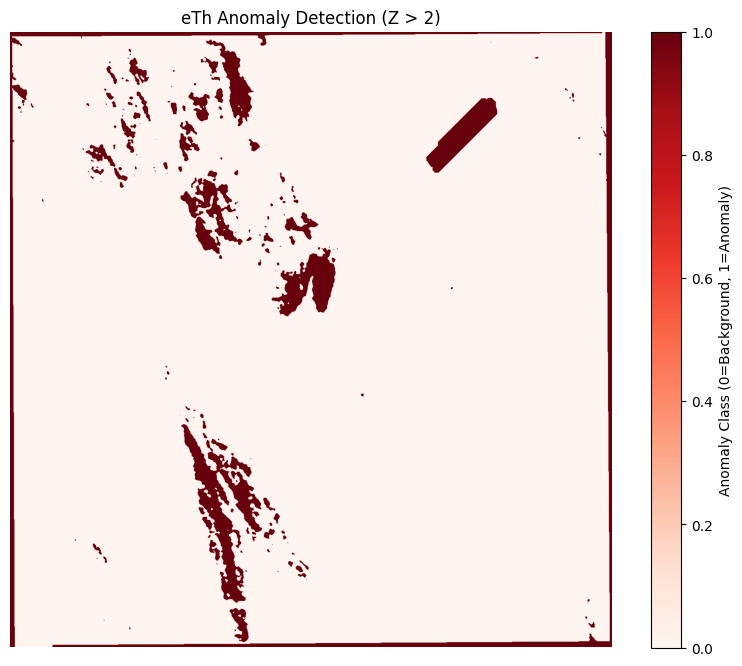

In [ ]:
import matplotlib.pyplot as plt
import rasterio

# Load the saved anomaly raster
anomaly_path = "eTh_anomaly.tif"

# Open the raster file
with rasterio.open(anomaly_path) as src:
    anomaly_data = src.read(1)  # Read the anomaly layer as a 2D array
    nodata = src.nodata

# Plot the anomaly layer
plt.figure(figsize=(10, 8))
plt.imshow(anomaly_data, cmap='Reds', vmin=0, vmax=1)  # Binary color map: 0 = background, 1 = anomaly
plt.title("eTh Anomaly Detection (Z > 2)")
plt.colorbar(label='Anomaly Class (0=Background, 1=Anomaly)')
plt.axis('off')  # Hide axis for a cleaner map
plt.show()
